In [2]:
import pandas as pd
from sqlalchemy import func
import matplotlib.pyplot as plt
import seaborn as sns
from db_conector import get_db_engine
from sqlalchemy.orm import Session
from modelo_tablas import (Usuarios, 
                           Categorias, 
                           Productos, 
                           Ordenes, 
                           DireccionesEnvio, 
                           Carrito, 
                           MetodosPago, 
                           OrdenesMetodosPago, 
                           ReseñasProductos, 
                           HistorialPagos,
                           DetalleOrdenes)

engine = get_db_engine()
session = Session(engine)

Motor de base de datos creado


## Exploración de las tablas

Ver usuarios mensuales

mes_registro
2025-07    1000
Freq: M, dtype: int64
mes_orden
2024-06     25
2024-07    828
2024-08    864
2024-09    806
2024-10    838
2024-11    807
2024-12    847
2025-01    844
2025-02    747
2025-03    842
2025-04    893
2025-05    861
2025-06    798
Freq: M, dtype: int64


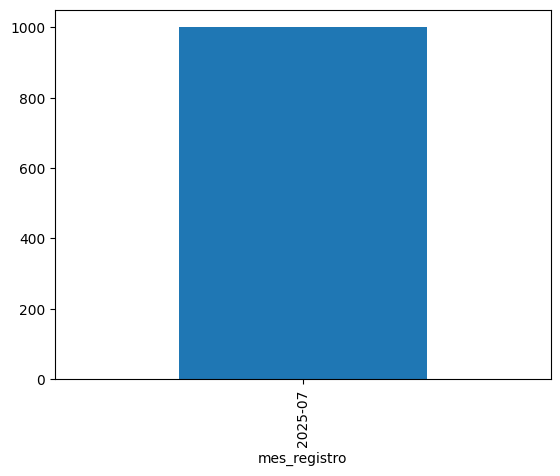

In [3]:
usuarios_query = session.query(Usuarios.usuario_id, Usuarios.fecha_registro).all()

if usuarios_query:
    # Convertir a DataFrame
    df_usuarios = pd.DataFrame(usuarios_query, columns=['usuario_id', 'fecha_registro'])
    df_usuarios['fecha_registro'] = pd.to_datetime(df_usuarios['fecha_registro'])
    df_usuarios['mes_registro'] = df_usuarios['fecha_registro'].dt.to_period('M')

    # Agrupar por mes y contar registros
    usuarios_mensuales = df_usuarios.groupby('mes_registro').size()

    # Mostrar primeras 10 filas
    print(usuarios_mensuales)

    # Generar gráfico de barras
    usuarios_mensuales.plot(kind='bar')

# Ordenes
ordenes_query = session.query(Ordenes.orden_id, Ordenes.fecha_orden).all()

if ordenes_query:
    # Convertir a DataFrame
    df_ordenes = pd.DataFrame(ordenes_query, columns=['orden_id', 'fecha_orden'])
    df_ordenes['fecha_orden'] = pd.to_datetime(df_ordenes['fecha_orden'])
    df_ordenes['mes_orden'] = df_ordenes['fecha_orden'].dt.to_period('M')

    # Agrupar por mes y contar registros
    ordenes_mensuales = df_ordenes.groupby('mes_orden').size()

    # Mostrar primeras 10 filas
    print(ordenes_mensuales)

Productos: Stock y Precios

    producto_id                      nombre  precio  stock
1             2     Laptop Dell Inspiron 15  799.00     30
33           34       Consola PlayStation 5  549.99     20
0             1       Smartphone Galaxy A54  349.99     50
9            10    Bicicleta Montaña Aro 29  299.00     20
2             3  Auriculares Bluetooth Sony  129.99    100
31           32          Mini Proyector LED   75.00     35
35           36         Juego FIFA 24 - PS5   69.99     30
5             6       Zapatillas Deportivas   59.99     80
34           35       Control Xbox Series X   59.99     50
13           14        Perfume Hombre 100ml   55.00     40
    producto_id                    nombre  precio  stock
9            10  Bicicleta Montaña Aro 29  299.00     20
33           34     Consola PlayStation 5  549.99     20
35           36       Juego FIFA 24 - PS5   69.99     30
1             2   Laptop Dell Inspiron 15  799.00     30
31           32        Mini Proyector LED   75.00     35
28       

<Axes: title={'center': 'Distribución de precios'}, ylabel='Frequency'>

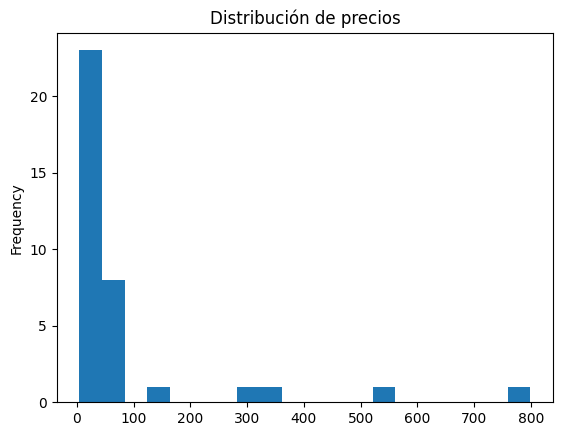

In [4]:
#Listar productos con sus precios y stock actual.
productos_query = session.query(Productos.producto_id, Productos.nombre, Productos.precio, Productos.stock).all()

df_productos = pd.DataFrame(productos_query, columns=['producto_id', 'nombre', 'precio', 'stock'])

# Ver cuáles son los productos más caros o con menos stock.

# Precios más altos
print(df_productos.sort_values('precio', ascending=False).head(10))

# Stock más bajo
print(df_productos.sort_values('stock').head(10))

# Histograma de precios
df_productos['precio'] = df_productos['precio'].astype(float)
df_productos['precio'].plot(kind='hist', bins=20, title='Distribución de precios')

Categorías: Cantidad de productos por categoría

<Axes: title={'center': 'Cantidad de productos por categoría'}, xlabel='categoria'>

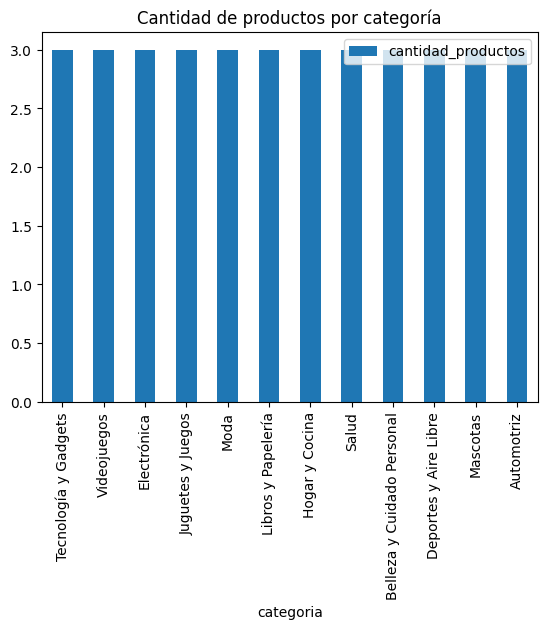

In [5]:
# Contar cuántos productos tiene cada categoría.
categorias_query = session.query(Categorias.nombre, func.count(Productos.producto_id)).join(Productos).group_by(Categorias.nombre).all()

df_categorias = pd.DataFrame(categorias_query, columns=['categoria', 'cantidad_productos'])
df_categorias.plot(kind='bar', x='categoria', y='cantidad_productos', title='Cantidad de productos por categoría')


Métodos de Pago: que método de pago es más utilizado

<Axes: title={'center': 'Uso de métodos de pago'}, xlabel='metodo_pago'>

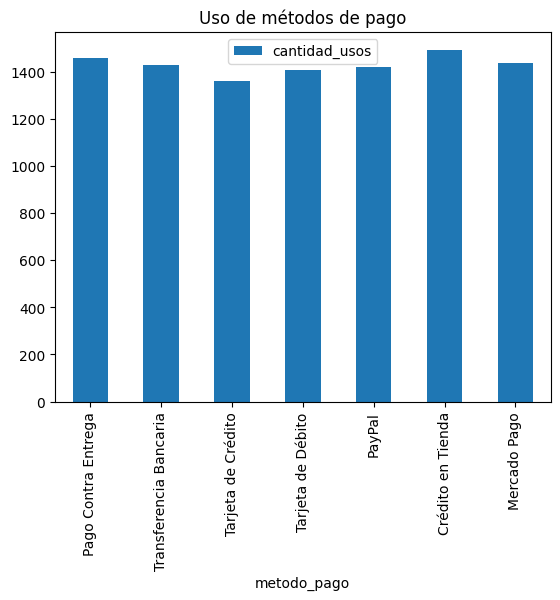

In [6]:
#Contar cuántas órdenes se pagaron con cada método que hay en la tabla
metodos_pago_query = session.query(MetodosPago.nombre, func.count(OrdenesMetodosPago.orden_metodo_id))\
    .join(OrdenesMetodosPago).group_by(MetodosPago.nombre).all()

df_metodos_pago = pd.DataFrame(metodos_pago_query, columns=['metodo_pago', 'cantidad_usos'])
df_metodos_pago.plot(kind='bar', x='metodo_pago', y='cantidad_usos', title='Uso de métodos de pago')



Carrito: ¿Qué productos se agregan más al carrito?

<Axes: title={'center': 'Productos más agregados al carrito'}, xlabel='producto_id'>

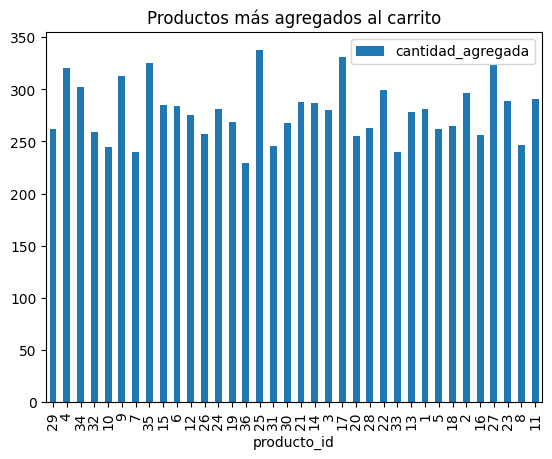

In [7]:
#Sumar la cantidad de veces que un producto fue agregado al carrito
carrito_query = session.query(Carrito.producto_id, func.sum(Carrito.cantidad)).group_by(Carrito.producto_id).all()

df_carrito = pd.DataFrame(carrito_query, columns=['producto_id', 'cantidad_agregada'])
df_carrito.plot(kind='bar', x='producto_id', y='cantidad_agregada', title='Productos más agregados al carrito')


Reseñas: Promedio de calificaciones por producto

<Axes: title={'center': 'Promedio de calificaciones por producto'}, xlabel='producto_id'>

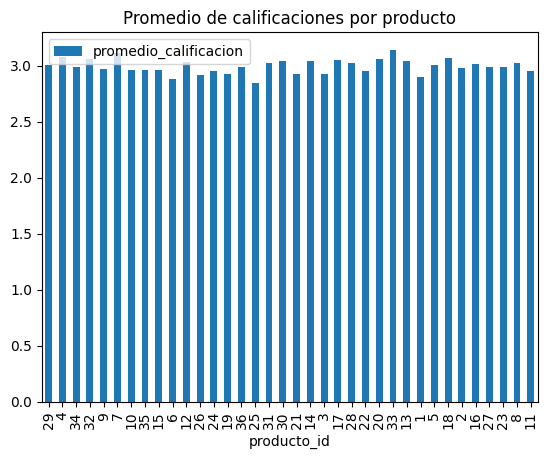

In [8]:
#Calcular promedio de las calificaciones dadas por usuarios a cada producto.
reseñas_query = session.query(ReseñasProductos.producto_id, func.avg(ReseñasProductos.calificacion))\
    .group_by(ReseñasProductos.producto_id).all()

df_reseñas = pd.DataFrame(reseñas_query, columns=['producto_id', 'promedio_calificacion'])
df_reseñas['promedio_calificacion'] = df_reseñas['promedio_calificacion'].astype(float)
df_reseñas.plot(kind='bar', 
                x='producto_id', 
                y='promedio_calificacion', 
                title='Promedio de calificaciones por producto')


Detalle Órdenes: Productos más vendidos
"¿Qué producto genera más ingresos?"
"¿Cuál es el más vendido?"

In [62]:
#Sumar la cantidad total vendida por producto.
ventas_query = session.query(
    DetalleOrdenes.producto_id,
    func.sum(DetalleOrdenes.cantidad).label('cantidad_vendida'),
    Productos.precio.label('precio_unitario')
).join(Productos, DetalleOrdenes.producto_id == Productos.producto_id)\
 .group_by(DetalleOrdenes.producto_id, Productos.precio).all()

df_ventas = pd.DataFrame(ventas_query, columns=['producto_id', 'cantidad_vendida', 'precio_unitario'])
df_ventas['ingresos'] = df_ventas['cantidad_vendida'] * df_ventas['precio_unitario']

df_ventas = df_ventas.sort_values('ingresos', ascending=False)
print(df_ventas.head(10))

    producto_id  cantidad_vendida precio_unitario   ingresos
15            2               847          799.00  676753.00
6            34               935          549.99  514240.65
29            1               837          349.99  292941.63
16           10               757          299.00  226343.00
26            3               819          129.99  106461.81
18           32               885           75.00   66375.00
3            36               855           69.99   59841.45
23           35               850           59.99   50991.50
28            6               825           59.99   49491.75
8            14               770           55.00   42350.00


¿Cómo crecen las ventas de ese producto mes a mes?"
"Cómo evoluciona en volumen y en ingresos."
KPI 1: Producto con mayor ingreso acumulado

<Axes: title={'center': 'Top productos por ingresos acumulados'}, xlabel='producto_id'>

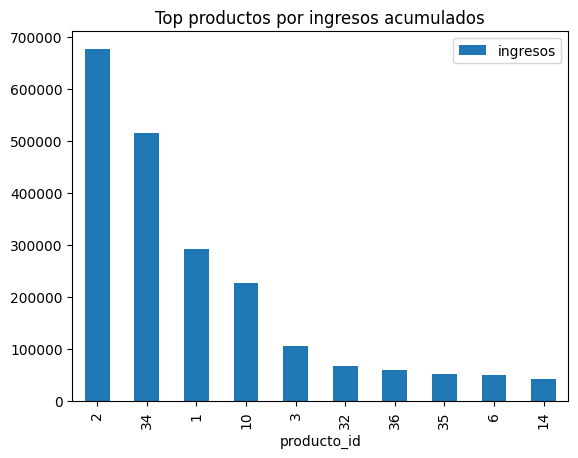

In [65]:
df_ventas['ingresos'] = pd.to_numeric(df_ventas['ingresos'], errors='coerce')
top_ingresos = df_ventas.sort_values('ingresos', ascending=False).head(10)
top_ingresos.plot(kind='bar', x='producto_id', y='ingresos', title='Top productos por ingresos acumulados')

In [66]:
ventas_mes_query = session.query(
    DetalleOrdenes.producto_id,
    Productos.nombre,
    func.date_trunc('month', Ordenes.fecha_orden).label('mes'),
    func.sum(DetalleOrdenes.cantidad).label('cantidad_vendida_mes'),
    Productos.precio.label('precio_unitario')
).join(Ordenes, DetalleOrdenes.orden_id == Ordenes.orden_id)\
 .join(Productos, DetalleOrdenes.producto_id == Productos.producto_id)\
 .group_by(DetalleOrdenes.producto_id, Productos.nombre, 'mes', Productos.precio)\
 .order_by('mes').all()

df_ventas_mes = pd.DataFrame(ventas_mes_query, columns=[
    'producto_id', 'nombre', 'mes', 'cantidad_vendida_mes', 'precio_unitario'
])

In [67]:
df_ventas_mes['tasa_crecimiento'] = df_ventas_mes.groupby('producto_id')['cantidad_vendida_mes'].pct_change()
df_crecimiento = (
    df_ventas_mes.groupby(['producto_id', 'nombre'])
    .agg({'tasa_crecimiento': 'mean'})
    .reset_index()
    .sort_values(by='tasa_crecimiento', ascending=False)
)

print(df_crecimiento.head(5))

    producto_id                       nombre  tasa_crecimiento
6             7    Sartén Antiadherente 24cm          6.567322
34           35        Control Xbox Series X          5.151476
15           16            Lego City Policía          5.075253
21           22  Libro: Cien Años de Soledad          2.445177
11           12       Mochila Deportiva Nike          2.046286


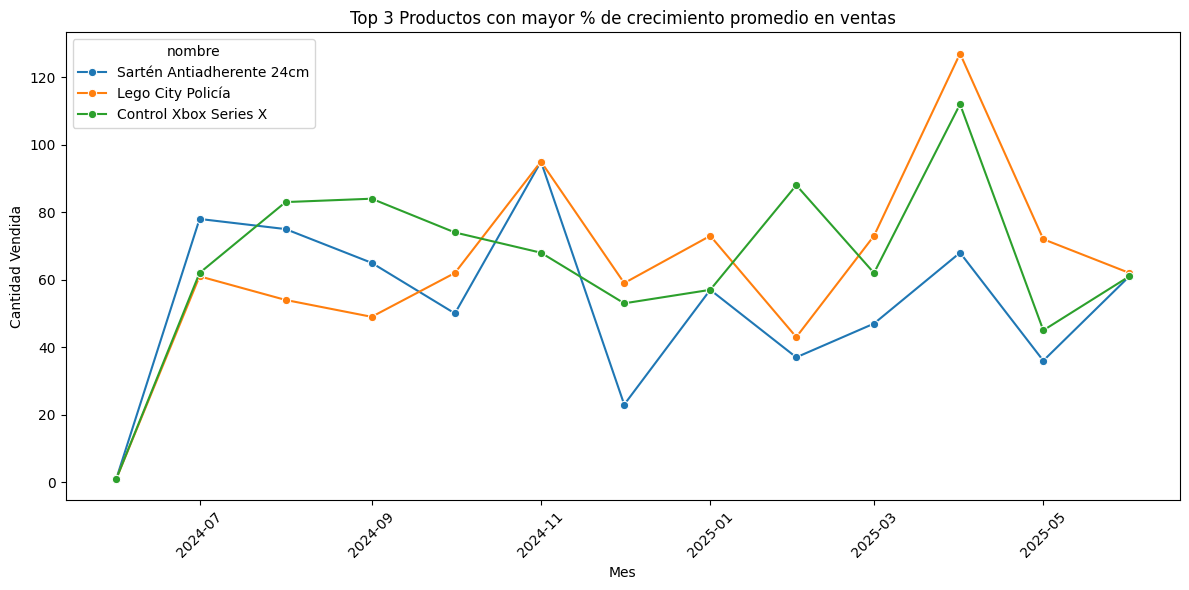

In [58]:
top3_crec = df_crecimiento.head(3)['producto_id']
df_top3_crec = df_ventas_mes[df_ventas_mes['producto_id'].isin(top3_crec)].copy()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_top3_crec, x='mes', y='cantidad_vendida_mes', hue='nombre', marker='o')
plt.title("Top 3 Productos con mayor % de crecimiento promedio en ventas")
plt.xlabel('Mes')
plt.ylabel('Cantidad Vendida')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [59]:
df_carrito = pd.DataFrame(carrito_query, columns=['producto_id', 'cantidad_agregada'])
df_carrito.sort_values('cantidad_agregada', ascending=False).head(5)

,producto_id,cantidad_agregada
15,25,338
21,17,331
7,35,325
32,27,323
1,4,321


Historial de Pagos: Monto total por mes

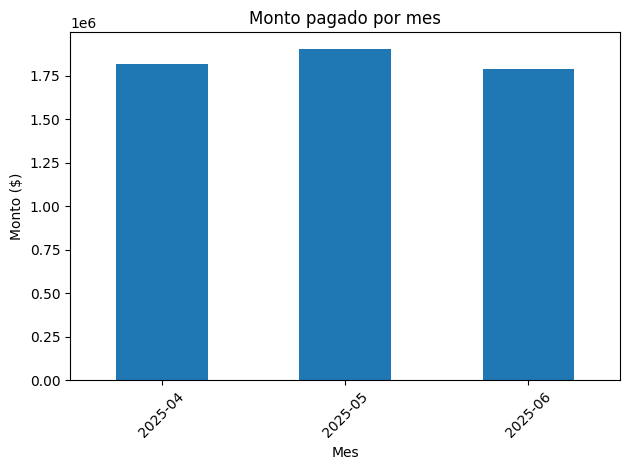

In [ ]:
#Sumar el monto total pagado en cada mes.
pagos_query = session.query(HistorialPagos.fecha_pago, HistorialPagos.monto).all()

df_pagos = pd.DataFrame(pagos_query, columns=['fecha_pago', 'monto'])
df_pagos['fecha_pago'] = pd.to_datetime(df_pagos['fecha_pago'])


df_pagos['monto'] = df_pagos['monto'].astype(float)

df_pagos['mes_pago'] = df_pagos['fecha_pago'].dt.to_period('M')

pagos_mensuales = df_pagos.groupby('mes_pago')['monto'].sum()

pagos_mensuales.index = pagos_mensuales.index.astype(str)

pagos_mensuales.plot(kind='bar', title='Monto pagado por mes')

import matplotlib.pyplot as plt
plt.ylabel('Monto ($)')
plt.xlabel('Mes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

